# Hedge MVP — Step-by-step Tutorial (Spot + Perp, OLS Hedge, Funding, ML Scaling)

**Goal:** running each function in isolation, checking the output, and visualizing as much as possible. This notebook uses your module `src/hedge_mvp/core.py` as the single source of truth.

**Covered:**
1. Fetch spot & perp OHLCV (`fetch_ohlcv`)
2. Align series (`align_close`)
3. Log returns (`compute_log_returns`)
4. Hedge ratio via OLS (`estimate_ols_hedge_ratio`)
5. Static hedge backtest (`backtest_static_hedge`) + metrics (variance reduction, Sharpe, MaxDD)
6. Funding rates (`fetch_funding_rates`) quick QA
7. ML features (`build_ml_vol_features`), optional XGB vol prediction, and `scale_hedge_ratio`
8. Save artifacts to `runs/.../hedge_mvp_tutorial/<TS>/`

## 00) Version diagnostic

In [1]:
import sys, subprocess, textwrap
print("Python:", sys.version)
print("Executable:", sys.executable)

def _pip_freeze_top(n=10):
    out = subprocess.check_output([sys.executable, "-m", "pip", "freeze"], text=True)
    print("\nTop of pip freeze:\n", "\n".join(out.splitlines()[:n]))
try:
    import numpy, pandas, matplotlib, statsmodels, ccxt
    print("numpy:", numpy.__version__)
    print("pandas:", pandas.__version__)
    print("matplotlib:", matplotlib.__version__)
    import statsmodels.api as sm; print("statsmodels:", sm.__version__)
    import ccxt; print("ccxt:", ccxt.__version__)
except Exception as e:
    print("Import check failed:", e)
    _pip_freeze_top()

Python: 3.8.12 (default, Feb  3 2022, 12:04:48) 
[Clang 13.0.0 (clang-1300.0.29.30)]
Executable: /Users/cintiamillan/Desktop/Nova IMS/crypto-vol-quickstart/.venv/bin/python
numpy: 1.24.4
pandas: 2.0.3
matplotlib: 3.7.5
statsmodels: 0.14.1
ccxt: 4.5.6


In [1]:
import os, sys, subprocess, time

# 1) Speed up matplotlib import (must be set BEFORE importing matplotlib)
os.environ.setdefault("MPLBACKEND", "Agg")       # non-GUI backend
os.environ.setdefault("MPLCONFIGDIR", ".mpl")    # writable cache in repo

t0 = time.perf_counter()
print("Python:", sys.version.split()[0])
print("Executable:", sys.executable)

def t(msg):
    print(f"[+{time.perf_counter()-t0:5.2f}s] {msg}")

try:
    t("importing numpy ...");      import numpy as np;            t(f"numpy {np.__version__} ok")
    t("importing pandas ...");     import pandas as pd;           t(f"pandas {pd.__version__} ok")
    t("importing matplotlib ..."); import matplotlib;             t(f"matplotlib {matplotlib.__version__} ok")
    t("importing statsmodels ...");import statsmodels.api as sm;  t(f"statsmodels {sm.__version__} ok")
    t("importing ccxt ...");       import ccxt;                   t(f"ccxt {ccxt.__version__} ok")
except Exception as e:
    print("Import check failed:", repr(e))
    # MUCH faster than 'pip freeze':
    try:
        out = subprocess.check_output([sys.executable, "-m", "pip", "list", "--format=freeze"], text=True, timeout=10)
        print("\nTop of pip list:\n", "\n".join(out.splitlines()[:10]))
    except Exception as ee:
        print("pip list also failed:", repr(ee))

Python: 3.8.12
Executable: /Users/cintiamillan/Desktop/Nova IMS/crypto-vol-quickstart/.venv/bin/python
[+ 0.00s] importing numpy ...
[+ 0.16s] numpy 1.24.4 ok
[+ 0.16s] importing pandas ...
[+ 0.57s] pandas 2.0.3 ok
[+ 0.57s] importing matplotlib ...
[+ 0.69s] matplotlib 3.7.5 ok
[+ 0.69s] importing statsmodels ...
[+ 1.99s] statsmodels 0.14.1 ok
[+ 1.99s] importing ccxt ...
[+ 2.64s] ccxt 4.5.6 ok


## 0) Setup & sanity checks

In [2]:
import os, json, math, datetime as dt
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# Libs for runtime display
import importlib, sys
from pathlib import Path

# Project imports — our core functions live here
from src.hedge_mvp.core import (
    ensure_dir, fetch_ohlcv, fetch_funding_rates, align_close, compute_log_returns,
    estimate_ols_hedge_ratio, backtest_static_hedge, sharpe_ratio, max_drawdown_from_returns,
    infer_periods_per_year, plot_series, plot_cumlogret,
    build_ml_vol_features, train_xgb_vol_model, predict_next_vol, scale_hedge_ratio,
)

# Basic display opts
pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 20)

# Versions (helpful for reproducibility)
import ccxt, statsmodels
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", plt.matplotlib.__version__)
print("ccxt:", ccxt.__version__)
print("statsmodels:", statsmodels.__version__)

# Try XGBoost (optional)
try:
    import xgboost
    HAS_XGB = True
    print("xgboost:", xgboost.__version__)
except Exception:
    HAS_XGB = False
    print("xgboost: NOT INSTALLED (ML step will be skipped)")

Python: 3.8.12
pandas: 2.0.3
numpy: 1.24.4
matplotlib: 3.7.5
ccxt: 4.5.6
statsmodels: 0.14.1
xgboost: NOT INSTALLED (ML step will be skipped)


## 1) Configuration
Pick symbols and timeframe. We start with BTC/USDT and 1h bars for quick iteration.

### 🧭 Cell 1 — **Configuration** (what we’re setting up and why)

Before we do any analysis, we define a few **inputs** so the notebook knows **which market**, **what data frequency**, and **where to save results**. Think of this as setting the **rules of the game**.

#### 1) **Market we’re analyzing**

*   SYMBOL\_SPOT = "BTC/USDT"We use **spot Bitcoin vs. Tether (USDT)**, i.e., the **actual asset price** you’d see if you bought/sold BTC **right now** on an exchange.
    
*   SYMBOL\_PERP = "BTC/USDT:USDT"We also load **perpetual futures** for the same pair. A **perpetual future (“perp”)** is a **derivative** that tracks the spot price **without an expiry date**. It’s widely used for **hedging** (reducing risk) or taking **long/short** exposure.The :USDT part tells our data source to use the **USDT-margined perp** (the common contract on Binance).Why we need both: **spot** represents the **thing we own**, and **perps** are the **tool we use to hedge** it.
    

#### 2) **Time resolution & sample size**

*   TIMEFRAME = "1h"We analyze **hourly bars** (each data point summarizes one hour of trading). Hourly data is a **good balance**: it’s **fast to iterate** and still captures **meaningful market moves**.
    
*   LIMIT = 1500We pull **1,500 hours** of history — about **62.5 days**. That’s enough to **train, validate, and demo** the workflow without waiting too long.Rule of thumb: more history = **more context** (better statistical stability), but also **slower runs**.
    

#### 3) **Organized outputs (reproducibility)**

We save every chart/table/file into a **run-specific folder** so results are **traceable** and **auditable** later.

*   RUNS\_SYM = SYMBOL\_SPOT.replace("/","").replace(":","")Creates a **clean label** for the asset (e.g., **BTCUSDT**) so folder names are tidy.
    
*   TS\_STR = dt.datetime.utcnow().strftime("%Y-%m-%d\_%H-%M-%S")Stamps the folder with the **current UTC time** (e.g., **2025-09-27\_16-45-12**).Why UTC? It’s a **universal clock**, avoiding confusion across **time zones**.
    
*   OUTDIR = os.path.join("runs", RUNS\_SYM, "hedge\_mvp\_tutorial", TS\_STR)Final path looks like:runs/ BTCUSDT / hedge\_mvp\_tutorial / 2025-09-27\_16-45-12This structure groups results by **asset**, **tutorial name**, and **timestamp**, making it **easy to compare** different runs.
    
*   ensure\_dir(OUTDIR)Makes sure the folder **exists** before we start writing results. This prevents **errors** and keeps the notebook **clean**.
    
*   Displaying OUTDIR at the end simply **shows you** where this run’s **artifacts** (figures, logs, tables) will be stored.
    

#### Why this matters (in plain English)

*   Choosing **spot vs. perp** sets up the **hedging story**: **spot** is what we’re protecting; **perps** are how we **offset risk**.
    
*   Picking an **hourly timeframe** helps us move **quickly** while still capturing **market dynamics**.
    
*   Saving to **timestamped folders** gives us **reproducibility**, **auditability**, and an easy way to **compare** different model settings later.
    

> **You can change these later** (e.g., try **ETH/USDT** or **4h** bars) — the structure stays the same, only the **inputs** change.

In [3]:
SYMBOL_SPOT = "BTC/USDT"
SYMBOL_PERP = "BTC/USDT:USDT"   # Binance USD-M perp routing via ccxt.binance()
TIMEFRAME   = "1h"
LIMIT       = 1500              # ~62 days of hourly data

# Where tutorial artifacts will be saved
RUNS_SYM = SYMBOL_SPOT.replace("/","").replace(":","")
TS_STR   = dt.datetime.utcnow().strftime("%Y-%m-%d_%H-%M-%S")
OUTDIR   = os.path.join("runs", RUNS_SYM, "hedge_mvp_tutorial", TS_STR)
ensure_dir(OUTDIR)
OUTDIR

'runs/BTCUSDT/hedge_mvp_tutorial/2025-09-27_16-30-25'

## 2) Fetch Spot OHLCV (`fetch_ohlcv`)
- Pulls candles via `ccxt.binance().fetch_ohlcv`
- Returns a DataFrame indexed by UTC timestamps with columns: open, high, low, close, volume

### 📈 Cell 2 — **Fetch Spot OHLCV** (what data we pull and basic checks)

This cell **downloads recent price data** for our chosen market and **runs a few quick quality checks** before we use it.

#### 1) **What we’re fetching**

*   **OHLCV** stands for **Open, High, Low, Close, Volume**:
    
    *   **Open**: price at the **start** of the hour
        
    *   **High**: **highest** price during that hour
        
    *   **Low**: **lowest** price during that hour
        
    *   **Close**: price at the **end** of the hour
        
    *   **Volume**: how much **BTC traded** in that hour (a demand/liquidity signal)
        
*   We use **ccxt** (a popular crypto data/trading library) to talk to **Binance** and fetch **hourly candles** (a “candle” = one hour of OHLCV info).
    
*   ccxt.binance() sets up a **connection** to the **exchange’s public market data**.
    
*   fetch\_ohlcv(...) pulls the **hourly candles** for our **spot market** (e.g., **BTC/USDT**) and returns a **table** (DataFrame) indexed by **UTC timestamps**.
    

#### 2) **Quick data health checks** (why they matter)

We check a few things to confirm the data looks **complete**, **time-consistent**, and **usable**:

*   **Shape**: how many rows and columns we got. If rows are fewer than expected, we might have **gaps**.
    
*   **Head/Tail**: first and last few rows so we can eyeball **columns**, **formats**, and **recent values**.
    
*   **Index tz-aware**: checks if timestamps are **timezone-aware**. We want **UTC** to avoid **time zone confusion** (critical for backtests and audits).
    
*   **Time span**: confirms our **coverage** (about **62 days** if LIMIT=1500 with **1h** bars).
    
*   **Any NA?**: shows if there are **missing values**. **Missing data** can **mislead models** and **distort charts**; we prefer to **clean or drop** it before analysis.
    

> Why this matters: confirming we have **clean, correctly-timed data** prevents **downstream errors** and **false conclusions**.

#### 3) **First look at the price** (sanity check plot)

We plot the **Close** price over time:

*   This gives an **at-a-glance view** of **market direction**, **volatility**, and any **obvious anomalies** (for example, sudden spikes or flat lines that might indicate data issues).
    
*   We focus on **Close** because it’s the **most commonly used reference price** for **returns**, **indicators**, and **hedge calculations**.
    

#### Takeaway (plain English)

*   We now have **hourly BTC spot data** (OHLCV) from **Binance**, **indexed in UTC**, with a quick **health check** and a **sanity plot**.
    
*   These checks ensure our later steps (like **hedging** and **volatility modeling**) rest on **solid, reliable inputs**.

spot_df shape: (1000, 5)


,open,high,low,close,volume
ts,,,,,
2025-08-17 01:00:00+00:00,117255.18,117491.44,117172.21,117439.97,244.13312
2025-08-17 02:00:00+00:00,117439.97,117624.55,117381.39,117606.00,157.36164
2025-08-17 03:00:00+00:00,117606.00,117771.37,117505.93,117684.95,209.36889


,open,high,low,close,volume
ts,,,,,
2025-09-27 14:00:00+00:00,109306.61,109387.51,109255.9,109287.89,273.62629
2025-09-27 15:00:00+00:00,109287.89,109427.40,109193.0,109402.24,204.90854
2025-09-27 16:00:00+00:00,109402.25,109420.00,109308.0,109362.23,91.12837


Index tz-aware: True
Time span: 2025-08-17 01:00:00+00:00 → 2025-09-27 16:00:00+00:00
Any NA?  {'open': False, 'high': False, 'low': False, 'close': False, 'volume': False}


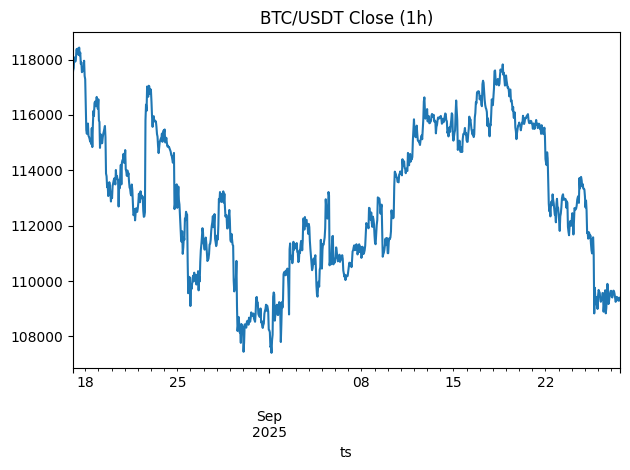

In [4]:
import ccxt
ex = ccxt.binance()
spot_df = fetch_ohlcv(ex, SYMBOL_SPOT, timeframe=TIMEFRAME, limit=LIMIT)
print("spot_df shape:", spot_df.shape)
display(spot_df.head(3))
display(spot_df.tail(3))
print("Index tz-aware:", spot_df.index.tz is not None)
print("Time span:", spot_df.index.min(), "→", spot_df.index.max())
print("Any NA? ", spot_df.isna().any().to_dict())

# Visualize spot close
plt.figure()
spot_df["close"].plot()
plt.title(f"{SYMBOL_SPOT} Close ({TIMEFRAME})")
plt.tight_layout(); plt.show()

## 3) Fetch Perp OHLCV (`fetch_ohlcv`) and quick QA

### 🔁 Cell 3 — **Fetch Perp OHLCV** + **Quick QA** (perpetual futures data check)

This cell pulls **perpetual futures (“perps”)** data for the same market and runs the **same health checks**. We use perps because they’re the **standard hedge instrument**: easy to **go short**, **no expiry**, and **deep liquidity**.

#### 1) **What we’re fetching (perps)**

*   **Perpetual futures** are **derivatives** designed to track the **spot price** closely, but they **never expire**.
    
*   Traders pay/receive a **funding rate** periodically so perp prices don’t drift too far from spot.
    
*   Here, we fetch **OHLCV** (**Open, High, Low, Close, Volume**) on an **hourly** basis, just like spot, to keep the **timeframes aligned**.
    

#### 2) **Quick data health checks** (same logic as spot)

We validate the basics so our **hedge math** isn’t built on **bad data**:

*   **Shape**: confirms **rows × columns**. Too few rows can mean **gaps**.
    
*   **Head/Tail**: quick look at **first/last** entries to eyeball **structure** and **recency**.
    
*   **Index tz-aware**: must be **UTC** to avoid **time zone mismatches** with spot.
    
*   **Time span**: should roughly **match the spot series** (about **62 days** with 1h bars if LIMIT=1500).
    
*   **Any NA?**: checks for **missing values** that could **distort returns** or **break plots**.
    

> **Why it matters:** our hedge compares **spot vs. perps** bar-by-bar. If timestamps or lengths **don’t line up**, the **hedge ratio** and performance will be **misleading**.

#### 3) **Sanity plot of perp Close**

*   We chart the **perp Close** to spot visual anomalies: **spikes**, **flat segments**, or **gaps**.
    
*   The perp Close should **track** the spot Close closely; **persistent deviations** can indicate **data issues** or **funding-related dislocations**.
    

#### Takeaway (plain English)

*   We now have **hourly perp OHLCV** aligned with **spot** and have verified **timezone, coverage, and missing data**.
    
*   With **clean, time-aligned series**, we can confidently compute **returns**, estimate a **hedge ratio (β)**, and evaluate **hedge effectiveness** without data artifacts skewing results.

perp_df shape: (1500, 5)


,open,high,low,close,volume
ts,,,,,
2025-07-27 05:00:00+00:00,118199.9,118286.3,118139.0,118258.2,1377.932
2025-07-27 06:00:00+00:00,118258.3,118432.1,118176.3,118240.1,1745.029
2025-07-27 07:00:00+00:00,118240.1,118240.1,118041.6,118083.6,1859.305


,open,high,low,close,volume
ts,,,,,
2025-09-27 14:00:00+00:00,109264.9,109346.0,109201.3,109244.0,1066.365
2025-09-27 15:00:00+00:00,109243.9,109384.6,109145.0,109340.7,2706.391
2025-09-27 16:00:00+00:00,109340.8,109369.6,109260.0,109332.8,925.717


Index tz-aware: True
Time span: 2025-07-27 05:00:00+00:00 → 2025-09-27 16:00:00+00:00
Any NA?  {'open': False, 'high': False, 'low': False, 'close': False, 'volume': False}


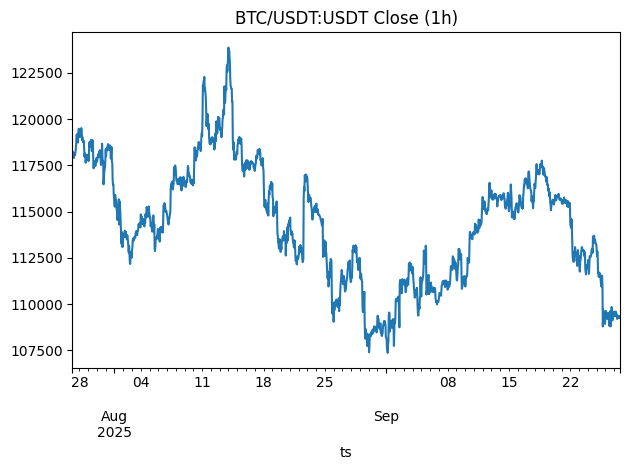

In [5]:
perp_df = fetch_ohlcv(ex, SYMBOL_PERP, timeframe=TIMEFRAME, limit=LIMIT)
print("perp_df shape:", perp_df.shape)
display(perp_df.head(3))
display(perp_df.tail(3))
print("Index tz-aware:", perp_df.index.tz is not None)
print("Time span:", perp_df.index.min(), "→", perp_df.index.max())
print("Any NA? ", perp_df.isna().any().to_dict())

# Visualize perp close
plt.figure()
perp_df["close"].plot()
plt.title(f"{SYMBOL_PERP} Close ({TIMEFRAME})")
plt.tight_layout(); plt.show()

## 4) Align series (`align_close`)
- Ensures both series share the same timestamps.
- We verify lengths & equality of indices.

### ⏱️ Cell 4 — **Align Series** (**align\_close**) (make spot & perp line up perfectly)

To compare **spot** and **perp** fairly (and to compute a **hedge ratio** later), both price series must have **identical timestamps**. This cell **aligns** the two series and **verifies** they match.

#### 1) **Why alignment matters**

*   Markets sometimes have **missing bars**, **maintenance gaps**, or **API hiccups**.
    
*   If **spot** has a bar that **perps** don’t (or vice-versa), any **bar-by-bar comparison** (returns, β estimation, hedge PnL) becomes **invalid**.
    
*   Alignment guarantees we’re comparing **the same hour with the same hour**, preventing **look-ahead bias** and **timestamp drift**.
    

#### 2) **What the function does**

*   **align\_close(spot\_df, perp\_df)**:
    
    *   Extracts the **Close** column from each series.
        
    *   **Joins** them on **common UTC timestamps** only (drops any bars that don’t exist in both).
        
    *   Returns two **time-aligned** Close series: **spot\_close** and **perp\_close**.
        

#### 3) **Quality checks after alignment**

*   **Aligned lengths**: both series should have the **same number of rows**.
    
*   **Same index?**: confirms the **timestamps are identical** and in **UTC**.
    
*   If either check fails, we’d need to **inspect gaps**, **re-fetch data**, or **decide on a fill strategy** (in trading, we usually **do not** forward-fill price bars for modeling/hedging).
    

#### 4) **Quick overlay plot** (visual sanity check)

*   We plot **Spot Close** and **Perp Close** on the **same chart**.
    
*   They should **track very closely**; small differences are normal due to **funding**, **microstructure noise**, or **spread**.
    
*   **Large or persistent divergences** could indicate **data errors**, **timestamp misalignment**, or unusual **market dislocations**.
    

#### Takeaway (plain English)

*   After this step, we have **clean, UTC-aligned Close series** for **spot** and **perps**.
    
*   This is the **foundation** for computing **returns**, estimating a **robust hedge ratio (β)**, and measuring **hedge effectiveness** without **timing errors** contaminating results.

Aligned lengths: 1000 1000
Same index? True


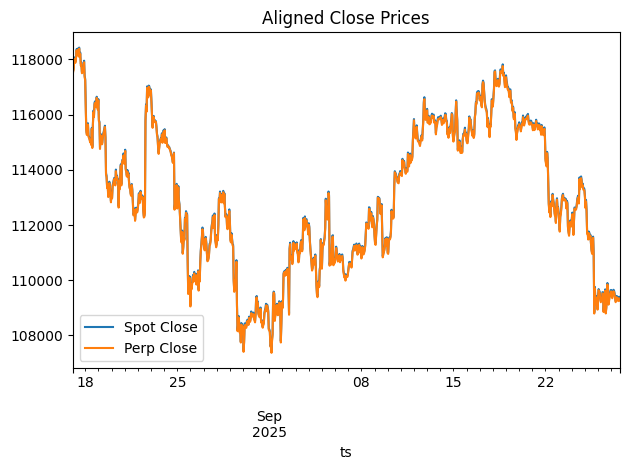

In [6]:
spot_close, perp_close = align_close(spot_df, perp_df)
print("Aligned lengths:", len(spot_close), len(perp_close))
print("Same index?", spot_close.index.equals(perp_close.index))

# Quick overlay plot
plt.figure()
spot_close.plot(label="Spot Close")
perp_close.plot(label="Perp Close")
plt.title("Aligned Close Prices")
plt.legend(); plt.tight_layout(); plt.show()

## 5) Compute log returns (`compute_log_returns`)
- We compute $r_t = \log(P_t) - \log(P_{t-1})$ for spot & perp.
- Inspect summary stats and simple distribution shape.

### 📊 Cell 5 — **Compute Log Returns** (**compute\_log\_returns**) (turn prices into analysis-ready series)

Prices are on an **arbitrary scale** (e.g., 25k vs. 100k) and aren’t directly comparable across assets or time. We convert prices to **log returns** to measure **percentage-like moves** in a way that is **time-additive** and statistically cleaner.

#### 1) **What we compute (and why log returns)**

*   **Definition:** $r_t = \log(P_t) - \log(P_{t-1})$. This is approximately the **percentage change** between periods, but with useful math properties:
    
    *   **Additivity over time:** multi-period log returns **sum** cleanly (helps aggregation and modeling).
        
    *   **Symmetry:** up/down moves are treated more **symmetrically** than simple percent returns.
        
    *   **Scale-free:** comparable across **assets** and **time**.
        
*   We compute **r\_spot** and **r\_perp** from the **aligned Close** prices so both series refer to the **same timestamps**.
    

#### 2) **Post-diff alignment (sanity check)**

*   Taking a **difference** removes the **first observation**, so we re-align the two return series and **drop NAs**.
    
*   We then inspect **summary statistics** (count, mean, std, min, max, and chosen percentiles like **1%, 5%, 95%, 99%**):
    
    *   **Mean (μ):** close to **0** in high-frequency crypto returns (markets are hard to predict intraday).
        
    *   **Std (σ):** a proxy for **volatility** at the chosen timeframe (here **1h**).
        
    *   **Tails (1% / 99%):** reveals **extreme moves**; crypto often shows **fat tails** (big jumps more common than Normal).
        

#### 3) **Distribution shape (histograms)**

*   We plot separate histograms for **r\_spot** and **r\_perp** (50 bins) to see:
    
    *   **Centering near 0:** typical for hourly returns.
        
    *   **Spread:** wider = more **volatile**.
        
    *   **Tail thickness:** **heavier tails** imply more **extreme events**, relevant for **risk limits** and **hedge sizing**.
        
*   Expect **r\_spot** and **r\_perp** to look **very similar** (perps track spot), with small differences due to **microstructure noise**, **liquidity**, and **funding dynamics** (funding itself is not in the Close-to-Close return unless you add it explicitly).
    

#### 4) **Short-lag autocorrelation (ACF)**

*   We compute the **autocorrelation** of **r\_spot** at **lags 1..5**:
    
    *   In liquid markets, raw returns usually show **near-zero autocorrelation** at short lags (consistent with **weak-form efficiency**).
        
    *   If you see **meaningful autocorrelation** (positive or negative), it can be due to **microstructure effects**, **timestamp issues**, or **market frictions**.
        
    *   More commonly, the **autocorrelation of squared (or absolute) returns** is **positive**—that’s **volatility clustering**, which motivates models like **GARCH** or **ML volatility forecasters**.
        

#### Takeaway (plain English)

*   We transformed prices into **clean, comparable return series** for **spot** and **perps**.
    
*   The **stats** and **histograms** tell us about **volatility** and **tail risk**; the **autocorrelation** check confirms whether returns behave like **noise** at short lags.
    
*   With **log returns** ready and quality-checked, we can proceed to **estimate a hedge ratio (β)** and evaluate **hedge performance** on firmer statistical ground.

,r_spot,r_perp
count,999.000000,999.000000
mean,-0.000071,-0.000071
std,0.003293,0.003291
min,-0.022484,-0.022376
1%,-0.009232,-0.009308
5%,-0.004637,-0.004588
50%,-0.000006,-0.000014
95%,0.004417,0.004443
99%,0.007638,0.007628
max,0.029097,0.029018


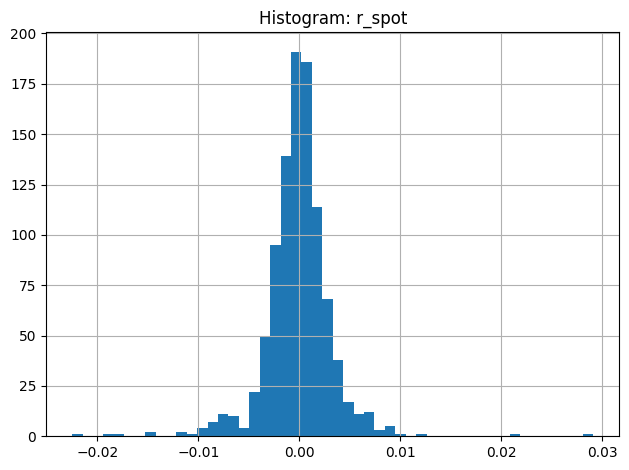

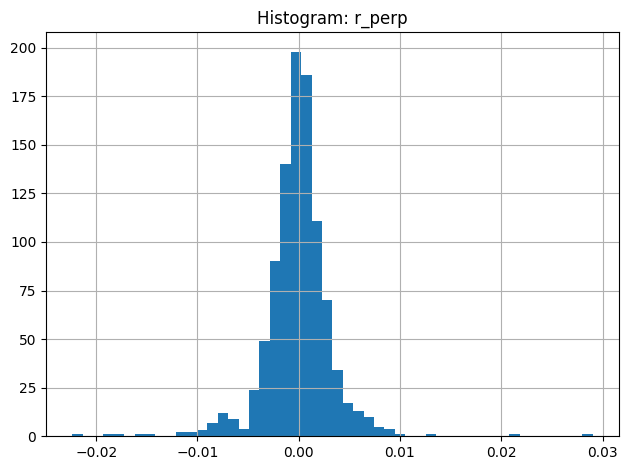

Autocorr r_spot lags 1..5: [0.0039, -0.0834, -0.0335, -0.0208, 0.0123]


In [7]:
r_spot = compute_log_returns(spot_close)
r_perp = compute_log_returns(perp_close)

# Sanity: aligned after diff
aligned = pd.concat([r_spot.rename("r_spot"), r_perp.rename("r_perp")], axis=1, join="inner").dropna()
display(aligned.describe(percentiles=[0.01,0.05,0.95,0.99]))

# Histograms (separate figures)
plt.figure()
aligned["r_spot"].hist(bins=50)
plt.title("Histogram: r_spot"); plt.tight_layout(); plt.show()

plt.figure()
aligned["r_perp"].hist(bins=50)
plt.title("Histogram: r_perp"); plt.tight_layout(); plt.show()

# Simple autocorrelation check for r_spot (lag-1..5)
acs = [aligned["r_spot"].autocorr(lag=k) for k in range(1,6)]
print("Autocorr r_spot lags 1..5:", [round(a,4) for a in acs])

## 6) Estimate hedge ratio via OLS (`estimate_ols_hedge_ratio`)
- Regression: spot returns ~ perp returns (with intercept)
- β (the slope) is the **hedge ratio** to minimize variance of the hedged portfolio

### 📐 Cell 6 — **Estimate Hedge Ratio via OLS** (**estimate\_ols\_hedge\_ratio**)

Here we estimate the **hedge ratio (β)** using a simple **linear regression** between spot and perp returns.

#### 1) **Why regression?**

The idea is:

*   We own **spot BTC** (exposed to risk).
    
*   We hedge with **perp contracts** (instrument to offset risk).
    
*   The hedge ratio **β** tells us **how much perp to hold against 1 unit of spot** in order to **minimize variance** of the combined portfolio.
    

This comes from an **ordinary least squares (OLS) regression**:

$$
r_t^{\text{spot}} = \alpha + \beta \, r_t^{\text{perp}} + \epsilon_t
$$  

**Where:**  

- $r_t^{\text{spot}}$ = spot return at time $t$  
- $r_t^{\text{perp}}$ = perp return at time $t$  
- $\alpha$ = intercept (average drift, often near 0)  
- $\beta$ = slope → the hedge ratio  
- $\epsilon_t$ = residual noise (part not explained by the hedge)  
    

#### 2) **Interpreting β (hedge ratio)**

*   If **β ≈ 1** → one unit of perp almost perfectly offsets one unit of spot.
    
*   If **β < 1** → perps move a bit more than spot; you hedge with **less than 1 perp per spot BTC**.
    
*   If **β > 1** → perps move less than spot; you need **more perps per spot BTC**.
    
*   A **stable, precise β** is essential: it makes the hedge **variance-minimizing** and reduces **unhedged risk**.
    

#### 3) **Optional regression summary**

We can also inspect the full OLS regression report (with **R²**, **standard errors**, etc.) if needed.But for the hedge, all we really need is **β**, the slope coefficient.

#### Takeaway (plain English)

*   This step estimates **how many perp contracts** we need to hold **per spot BTC** to create a **variance-minimizing hedge**.
    
*   The result is the **core parameter (β)** for the hedge strategy.

In [8]:
beta = estimate_ols_hedge_ratio(r_spot, r_perp)
print("Estimated OLS hedge ratio (β):", round(beta, 6))

# (Optional) peek at regression summary by re-running manually
# import statsmodels.api as sm
# y = aligned["r_spot"].values
# X = sm.add_constant(aligned["r_perp"].values)
# model = sm.OLS(y, X).fit()
# print(model.summary())

Estimated OLS hedge ratio (β): 1.000451


## 7) Backtest static hedge (`backtest_static_hedge`) + metrics
- Construct hedged returns: $r_t^{\text{hedged}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}}$
- Report variance reduction, Sharpe, Max Drawdown
- Visualize cumulative **log** returns (additive over time)

### 🛡️ Cell 7 — **Backtest Static Hedge** (**backtest\_static\_hedge**) + Metrics

Now we test the **hedge in action**: what happens if we combine **spot returns** with **perp returns scaled by β**?

#### 1) **Hedged return formula**

We construct the hedged return as:

$$
r_t^{\text{hedged}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}}
$$  

**Where:**  
- $r_t^{\text{spot}}$ = spot return at time $t$  
- $r_t^{\text{perp}}$ = perp return at time $t$  
- $\beta$ = hedge ratio estimated earlier  
- $r_t^{\text{hedged}}$ = return of the hedged portfolio at time $t$  
    

Intuition: the hedge works by **subtracting out** some fraction of perp returns to **cancel volatility** in spot.

#### 2) **Variance reduction**

*   **Variance** = statistical measure of return variability (risk).
    
*   We compare:
    
    *   Variance of **unhedged spot**
        
    *   Variance of **hedged portfolio**
        
*   The key metric is:
    

 $$
   \text{Variance Reduction} = 1 - \frac{\text{Var}(r^{\text{hedged}})}{\text{Var}(r^{\text{spot}})}
   $$  

*   A higher percentage means the hedge is **more effective** at reducing risk.
    
*   Example: 80% variance reduction = hedge cuts volatility by 4×.
    

#### 3) **Sharpe ratio (risk-adjusted performance)**

*   **Sharpe ratio = mean return ÷ volatility**.
    
*   Interprets returns in units of **risk taken**.
    
*   We compute Sharpe for both **spot** and **hedged**:
    
    *   If the hedge cuts volatility **a lot**, Sharpe should **increase** (assuming returns don’t collapse).
        

#### 4) **Max Drawdown (MDD)**

*   The **largest peak-to-trough loss** in the cumulative return curve.
    
*   Captures **worst-case downside** an investor would face.
    
*   Lower drawdown = hedge gave **better downside protection**.
    

#### 5) **Visualization — cumulative log returns**

*   We plot **cumulative log returns** for both spot and hedged.
    
*   Why log returns? They are **additive over time**, so cumulative sums give a clean curve.
    
*   Interpretation:
    
    *   **Spot curve** = risk of holding BTC unhedged (high volatility swings).
        
    *   **Hedged curve** = smoother path with reduced variance and smaller drawdowns.

---

### 📐 Static Hedge with and without Funding

**Baseline (no funding):**

$$
r_t^{\text{hedged}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}}
$$  

**With funding included:**

$$
r_t^{\text{hedged, fund}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}} + f_t
$$  

**Where:**  
- $r_t^{\text{spot}}$ = spot return at time $t$  
- $r_t^{\text{perp}}$ = perp return at time $t$  
- $\beta$ = hedge ratio (contracts per unit of spot)  
- $f_t$ = funding return at time $t$  
   - $f_t > 0$ if we **receive funding**  
   - $f_t < 0$ if we **pay funding**  

### 📊 Interpretation

- If perps trade **above spot** (bullish), longs pay shorts → hedger (short perp) **receives funding**.  
- If perps trade **below spot** (bearish), shorts pay longs → hedger **pays funding**.  
- Over time, $\sum f_t$ can either **enhance** or **erode** the hedge’s benefits from variance reduction.  

---

### 📉 Variance Reduction — With and Without Funding

**Without funding:**  

$$
\text{Variance Reduction} 
= 1 - \frac{\text{Var}\!\left(r_t^{\text{hedged}}\right)}{\text{Var}\!\left(r_t^{\text{spot}}\right)}
$$  

**With funding:**  

$$
\text{Variance Reduction (funding-adjusted)} 
= 1 - \frac{\text{Var}\!\left(r_t^{\text{hedged, fund}}\right)}{\text{Var}\!\left(r_t^{\text{spot}}\right)}
$$  


**Where:**  
- $r_t^{\text{spot}}$ = spot return at time $t$  
- $r_t^{\text{hedged}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}}$ (static hedge without funding)  
- $r_t^{\text{hedged, fund}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}} + f_t$ (hedge including funding)  
- $\text{Var}(\cdot)$ = variance operator  


### 📊 Interpretation

- The **first formula** shows variance reduction from **hedging only with perps**.  
- The **second formula** includes **funding effects**, giving a more realistic measure of **total hedge effectiveness**.  
- Comparing the two tells us how much of the hedge benefit comes from **statistical variance reduction** vs. how much is offset or enhanced by **funding payments**.  

---

### 📉 Worked Example — Variance Reduction (VR)

**Formulas:**
\[
\mathrm{VR}
= 1 - \frac{\mathrm{Var}\!\left(r_t^{\mathrm{hedged}}\right)}{\mathrm{Var}\!\left(r_t^{\mathrm{spot}}\right)},
\qquad
\mathrm{VR}_{\mathrm{fund}}
= 1 - \frac{\mathrm{Var}\!\left(r_t^{\mathrm{hedged,\,fund}}\right)}{\mathrm{Var}\!\left(r_t^{\mathrm{spot}}\right)}
\]

**Assume per-period variances (example numbers):**
\[
\mathrm{Var}\!\left(r_t^{\mathrm{spot}}\right) = 4.0\times 10^{-5}, \qquad
\mathrm{Var}\!\left(r_t^{\mathrm{hedged}}\right) = 8.0\times 10^{-6}, \qquad
\mathrm{Var}\!\left(r_t^{\mathrm{hedged,\,fund}}\right) = 9.0\times 10^{-6}.
\]

**Compute VR (no funding):**
\[
\mathrm{VR}
= 1 - \frac{8.0\times 10^{-6}}{4.0\times 10^{-5}}
= 1 - 0.20
= \mathbf{0.80}\; \text{(i.e., 80\% variance reduction)}.
\]

**Compute VR (with funding):**
\[
\mathrm{VR}_{\mathrm{fund}}
= 1 - \frac{9.0\times 10^{-6}}{4.0\times 10^{-5}}
= 1 - 0.225
= \mathbf{0.775}\; \text{(i.e., 77.5\% variance reduction)}.
\]

**Interpretation:** In this example, the static hedge cuts variance by **80\%**. After including funding effects, effective variance reduction is **77.5\%** — still substantial, but slightly lower due to funding variability.

---

### 📈 Sharpe Ratio — With and Without Funding

**General definition (annualized):**

$$
\mathrm{Sharpe}(r) = \frac{\mathbb{E}[\,r_t\,]}{\sigma(r_t)} \; \sqrt{A}
$$

where  
- $\mathbb{E}[\,r_t\,]$ = expected (mean) return per period  
- $\sigma(r_t)$ = standard deviation (volatility) per period  
- $A$ = periods per year (e.g., $A = 24 \times 365$ for hourly data)


**Spot:**

$$
\mathrm{Sharpe}_{\text{spot}}
= \frac{\mathbb{E}\!\left[r_t^{\text{spot}}\right]}{\sigma\!\left(r_t^{\text{spot}}\right)} \; \sqrt{A}
$$

**Hedged (no funding):**

$$
\mathrm{Sharpe}_{\text{hedged}}
= \frac{\mathbb{E}\!\left[r_t^{\text{hedged}}\right]}{\sigma\!\left(r_t^{\text{hedged}}\right)} \; \sqrt{A},
\qquad
r_t^{\text{hedged}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}}
$$

**Hedged (with funding):**

$$
\mathrm{Sharpe}_{\text{hedged, fund}}
= \frac{\mathbb{E}\!\left[r_t^{\text{hedged, fund}}\right]}{\sigma\!\left(r_t^{\text{hedged, fund}}\right)} \; \sqrt{A},
\qquad
r_t^{\text{hedged, fund}} = r_t^{\text{spot}} - \beta \, r_t^{\text{perp}} + f_t
$$

---

### 📉 Max Drawdown — With and Without Funding

**Definition (in terms of cumulative log returns):**

$$
\text{MDD}(R) = \max_{t} \left( \frac{M_t - R_t}{M_t} \right)
$$

where  
- $R_t$ = cumulative return at time $t$  
- $M_t = \max_{s \leq t} R_s$ = running maximum of cumulative returns up to time $t$  
- $\text{MDD}(R)$ = the largest peak-to-trough loss observed  


**Spot:**

$$
\text{MDD}_{\text{spot}} 
= \max_{t} \left( \frac{M_t^{\text{spot}} - R_t^{\text{spot}}}{M_t^{\text{spot}}} \right)
$$

**Hedged (no funding):**

$$
\text{MDD}_{\text{hedged}} 
= \max_{t} \left( \frac{M_t^{\text{hedged}} - R_t^{\text{hedged}}}{M_t^{\text{hedged}}} \right),
\qquad
R_t^{\text{hedged}} = \sum_{\tau \leq t} r_\tau^{\text{hedged}}
$$

**Hedged (with funding):**

$$
\text{MDD}_{\text{hedged, fund}} 
= \max_{t} \left( \frac{M_t^{\text{hedged, fund}} - R_t^{\text{hedged, fund}}}{M_t^{\text{hedged, fund}}} \right),
\qquad
R_t^{\text{hedged, fund}} = \sum_{\tau \leq t} r_\tau^{\text{hedged, fund}}
$$

---

#### Takeaway (plain English)

*   The hedge is now **quantified**: we can see how much risk reduction we gained.
    
*   By comparing **variance, Sharpe, and drawdown**, we learn not just if the hedge reduces volatility, but whether it makes the **risk-adjusted performance** better.

Variance (Spot):    1.084573e-05
Variance (Hedged):  7.476962e-09
Variance reduction: 99.93%
Sharpe Spot/Hedged: -2.027 / -0.193
MaxDD  Spot/Hedged: -9.53% / -0.05%


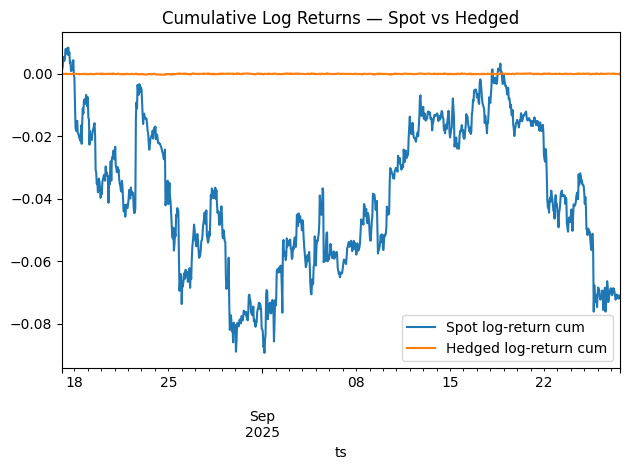

In [9]:
r_sp_al, r_hedged = backtest_static_hedge(r_spot, r_perp, beta)

var_spot = float(r_sp_al.var())
var_hedged = float(r_hedged.var())
variance_reduction = 1.0 - (var_hedged/var_spot) if var_spot>0 else 0.0

periods = infer_periods_per_year(TIMEFRAME)
sr_spot = sharpe_ratio(r_sp_al, periods)
sr_hedged = sharpe_ratio(r_hedged, periods)
mdd_spot = max_drawdown_from_returns(r_sp_al)
mdd_hedged = max_drawdown_from_returns(r_hedged)

print("Variance (Spot):   ", f"{var_spot:.6e}")
print("Variance (Hedged): ", f"{var_hedged:.6e}")
print("Variance reduction:", f"{variance_reduction:.2%}")
print("Sharpe Spot/Hedged:", round(sr_spot,3), "/", round(sr_hedged,3))
print("MaxDD  Spot/Hedged:", f"{mdd_spot:.2%}", "/", f"{mdd_hedged:.2%}")

# Cumulative log returns
plt.figure()
r_sp_al.cumsum().plot(label="Spot log-return cum")
r_hedged.cumsum().plot(label="Hedged log-return cum")
plt.title("Cumulative Log Returns — Spot vs Hedged")
plt.legend(); plt.tight_layout(); plt.show()

## 8) Funding rates (`fetch_funding_rates`)
- Snapshot of recent perp funding; useful context for regimes & hedge costs.
- Not all ccxt routes expose history; this returns an empty DF if unsupported.

### 💸 Cell 8 — **Funding Rates** (**fetch\_funding\_rates**)

Perpetual futures don’t expire, so they rely on a **funding mechanism** to keep perp prices close to spot. This cell fetches recent **funding rates** for the perp contract and gives context for **hedge costs**.

#### 1) **What are funding rates?**

*   Perps are designed to **track the spot market**, but since they never settle, exchanges use **funding payments** to keep prices aligned.
    
*   At regular intervals (often every **8 hours** on Binance):
    
    *   If the perp trades **above spot**, **longs pay shorts** a funding fee.
        
    *   If the perp trades **below spot**, **shorts pay longs**.
        
*   For a hedger:
    
    *   Holding a **short perp** (to hedge spot BTC) means you **pay funding when longs dominate**, and **receive funding when shorts dominate**.
        
    *   Over time, this cost (or income) can significantly impact hedge performance.
        

#### 2) **Fetching the data**

*   We ask Binance (via ccxt) for the last ~200 funding events.
    
*   Not all exchanges expose this data through ccxt. If unsupported, the result is simply an **empty table**.
    
*   If available, we see a **DataFrame** with timestamps and funding values (often expressed as a fraction, e.g., 0.01% per period).
    

#### 3) **Quick plot of funding rates**

*   If the data includes a **fundingRate** column, we plot the recent history.
    
*   This shows how funding has been fluctuating:
    
    *   **Positive spikes** → longs are paying shorts (hedgers benefit).
        
    *   **Negative dips** → shorts are paying longs (hedgers pay cost).
        

#### 4) **Why it matters**

*   Even if the **hedge reduces variance** strongly, funding can turn it into a **net cost** or **profit** depending on market regimes.
    
*   In practice:
    
    *   During bullish periods (perp > spot), hedgers often **earn funding**.
        
    *   During bearish periods (perp < spot), hedgers may **pay funding**.
        
*   Thus, funding dynamics are part of the **total hedge economics**.

---

### 📐 Hedge PnL with Funding

When using perps to hedge, the **total hedged PnL** must also include **funding payments**.  

**Formula:**  

$$
\text{PnL}^{\text{hedged}}_t 
= r_t^{\text{spot}} 
- \beta \, r_t^{\text{perp}} 
\;\; \pm \;\; \text{Funding}_t
$$  

**Where:**  
- $r_t^{\text{spot}}$ = spot return at time $t$  
- $r_t^{\text{perp}}$ = perp return at time $t$  
- $\beta$ = hedge ratio (contracts per BTC spot)  
- $\text{Funding}_t$ = funding payment at time $t$  
   - Positive if we **receive funding**  
   - Negative if we **pay funding**  


### 📊 Interpretation

- In a **bullish market** (perps > spot):  
  - Shorts **receive** funding → hedgers **gain extra income**.  

- In a **bearish market** (perps < spot):  
  - Shorts **pay** funding → hedgers face an **extra cost**.  

So, even if the hedge cuts volatility, funding determines whether the hedge is a **net benefit** or a **drag** over time.  

---

#### Takeaway (plain English)

*   Funding is the **hidden cost or bonus** of running a hedge with perps.
    
*   Checking recent funding rates helps us understand **when hedging is cheap or expensive**, and whether hedge performance should be interpreted **before or after funding costs**.

fund_df shape: (200, 5)


,info,symbol,fundingRate,timestamp,datetime
ts,,,,,
2025-07-23 08:00:00.004000+00:00,"{'symbol': 'BTCUSDT', 'fundingTime': '17532576...",BTC/USDT:USDT,0.0001,1753257600004,2025-07-23T08:00:00.004Z
2025-07-23 16:00:00.002000+00:00,"{'symbol': 'BTCUSDT', 'fundingTime': '17532864...",BTC/USDT:USDT,0.0001,1753286400002,2025-07-23T16:00:00.002Z
2025-07-24 00:00:00+00:00,"{'symbol': 'BTCUSDT', 'fundingTime': '17533152...",BTC/USDT:USDT,0.0001,1753315200000,2025-07-24T00:00:00.000Z


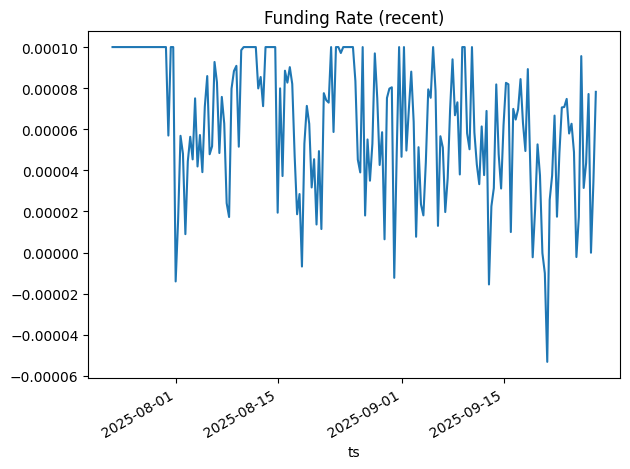

In [10]:
fund_df = fetch_funding_rates(ex, SYMBOL_PERP, limit=200)
print("fund_df shape:", fund_df.shape)
display(fund_df.head(3))

# If it has a "fundingRate" column, quick plot:
if "fundingRate" in fund_df.columns:
    plt.figure()
    fund_df["fundingRate"].astype(float).plot()
    plt.title("Funding Rate (recent)")
    plt.tight_layout(); plt.show()

## 9) ML features + optional XGBoost vol prediction & hedge scaling
- Build simple volatility features (`build_ml_vol_features`)
- If xgboost is installed, train a tiny model to predict next-step vol proxy
- Map predicted vol to a scale in [scale_min, scale_max] and apply to β

### 🤖 Cell 9 — **ML Features + Optional XGBoost Volatility Prediction & Hedge Scaling**

This step shows how we can make the hedge **adaptive** by letting machine learning estimate **volatility regimes** and then adjusting the hedge ratio **β** accordingly.

#### 1) **Feature construction**

*   We build a **feature DataFrame** (feat\_df) with rolling statistics of returns, e.g.:
    
    *   **Rolling volatilities** (e.g. last 48h).
        
    *   **Autocorrelation or realized variance proxies**.
        
    *   A **“target vol”** column as the label we want to predict (next-step volatility).
        
*   These features turn raw returns into something an ML model can learn from.
    

#### 2) **XGBoost model (optional)**

*   If **XGBoost** is installed, we train a **tiny gradient boosting model** to predict the **next-step volatility proxy**.
    
*   It learns from the last 200+ rows of features (rolling windows).
    
*   The model’s output is a **predicted volatility (pred\_vol)** for the **next period**.
    

Why useful?

*   Volatility tends to **cluster**: calm periods are followed by calm, turbulent by turbulent.
    
*   Even a simple ML model can capture this persistence and give us a **forward-looking vol estimate**.
    

#### 3) **Scaling the hedge ratio**

*   The raw OLS hedge ratio β is **static**.
    
### 🔧 Hedge Ratio Scaling Formula

We adjust the static hedge ratio $\beta$ based on the predicted next-step volatility $\hat{\sigma}_{t+1}$.

**Definition:**

$$
\beta_{\text{scaled}}(\hat{\sigma}_{t+1}) 
= \beta \cdot \left[
\; \text{scale\_min} \;+\;
\frac{\hat{\sigma}_{t+1} - \text{vol}_{\text{low}}}{\text{vol}_{\text{high}} - \text{vol}_{\text{low}}}
\cdot \left(\text{scale\_max} - \text{scale\_min}\right)
\;\right]
$$

**Where:**

- $\beta$ = static OLS hedge ratio  
- $\hat{\sigma}_{t+1}$ = predicted next-step volatility  
- $\text{vol}_{\text{low}}$ = lower volatility bound (e.g. 20th percentile of recent vols)  
- $\text{vol}_{\text{high}}$ = upper volatility bound (e.g. 80th percentile of recent vols)  
- $\text{scale\_min}, \text{scale\_max}$ = chosen limits for scaling (e.g. 0.3 → 1.2)


**Interpretation:**

- If $\hat{\sigma}_{t+1} \approx \text{vol}_{\text{low}}$ → $\beta_{\text{scaled}} \approx \beta \cdot \text{scale\_min}$ (light hedge in calm regime).  
- If $\hat{\sigma}_{t+1} \approx \text{vol}_{\text{high}}$ → $\beta_{\text{scaled}} \approx \beta \cdot \text{scale\_max}$ (aggressive hedge in turbulent regime).  
- Intermediate volatilities interpolate smoothly between the two extremes.

        
*   Intuition:
    
    *   In **calm regimes**, hedge less aggressively (scaled β closer to 0.3).
        
    *   In **volatile regimes**, hedge more aggressively (scaled β up to 1.2).
 
---

### 🧱 Piecewise Hedge Ratio Scaling (with caps)

$$
\beta_{\text{scaled}}(\hat{\sigma}_{t+1}) =
\begin{cases}
\beta \cdot \text{scale\_min}, & \hat{\sigma}_{t+1} \leq \text{vol}_{\text{low}}, \\[8pt]
\beta \cdot \left[\;
\text{scale\_min} +
\dfrac{\hat{\sigma}_{t+1} - \text{vol}_{\text{low}}}{\text{vol}_{\text{high}} - \text{vol}_{\text{low}}}
\;(\text{scale\_max} - \text{scale\_min})
\;\right], & \text{vol}_{\text{low}} < \hat{\sigma}_{t+1} < \text{vol}_{\text{high}}, \\[12pt]
\beta \cdot \text{scale\_max}, & \hat{\sigma}_{t+1} \geq \text{vol}_{\text{high}}.
\end{cases}
$$

**Equivalent clipped-linear form:**

$$
\beta_{\text{scaled}}(\hat{\sigma}_{t+1})
= \beta \cdot \left[
\text{scale\_min} +
\dfrac{
\min\!\big(\max(\hat{\sigma}_{t+1}, \, \text{vol}_{\text{low}}), \, \text{vol}_{\text{high}}\big) - \text{vol}_{\text{low}}
}{\text{vol}_{\text{high}} - \text{vol}_{\text{low}}}
\;(\text{scale\_max} - \text{scale\_min})
\right].
$$


### 🔢 Worked Numerical Example (Hedge Ratio Scaling)

**Given parameters:**

$$
\beta = 1.00, \quad \text{scale}_{\min}=0.3, \quad \text{scale}_{\max}=1.2, \quad
\text{vol}_{\text{low}}=0.01, \quad \text{vol}_{\text{high}}=0.05
$$

**Rule:**

$$
\beta_{\text{scaled}}(\hat{\sigma}) =
\begin{cases}
\beta \cdot \text{scale}_{\min}, & \hat{\sigma} \leq \text{vol}_{\text{low}}, \\[8pt]
\beta \cdot \Bigg[\text{scale}_{\min} +
\dfrac{\hat{\sigma} - \text{vol}_{\text{low}}}{\text{vol}_{\text{high}} - \text{vol}_{\text{low}}}
\big(\text{scale}_{\max} - \text{scale}_{\min}\big)\Bigg], & \text{vol}_{\text{low}} < \hat{\sigma} < \text{vol}_{\text{high}}, \\[12pt]
\beta \cdot \text{scale}_{\max}, & \hat{\sigma} \geq \text{vol}_{\text{high}}.
\end{cases}
$$


**1) Calm regime (below lower bound):**

$$
\hat{\sigma} = 0.008 < 0.01 \quad \Rightarrow \quad
\beta_{\text{scaled}} = 1.00 \times 0.3 = \mathbf{0.30}
$$


**2) Mid regime (between bounds):**

$$
\hat{\sigma} = 0.03, \quad
\frac{\hat{\sigma} - 0.01}{0.05 - 0.01} = \frac{0.02}{0.04} = 0.5
$$

$$
\text{scale} = 0.3 + 0.5 \times (1.2 - 0.3) = 0.3 + 0.45 = 0.75
$$

$$
\beta_{\text{scaled}} = 1.00 \times 0.75 = \mathbf{0.75}
$$


**3) Turbulent regime (above upper bound):**

$$
\hat{\sigma} = 0.07 > 0.05 \quad \Rightarrow \quad
\beta_{\text{scaled}} = 1.00 \times 1.2 = \mathbf{1.20}
$$

---

#### 4) **Visualization**

*   We generate a grid of **hypothetical volatility levels** and plot the corresponding **scaled β**.
    
*   The curve shows how the hedge ratio **responds smoothly to volatility predictions**.
    

#### 5) **Fallback behavior**

*   If XGBoost isn’t installed or not enough history is available, the notebook **skips ML scaling** and keeps the **static β**.
    
*   This ensures the workflow is still reproducible without ML dependencies.
    

#### Takeaway (plain English)

*   This cell shows how we can **enhance a static hedge** with **machine learning**:
    
    *   Build volatility features → train a small ML model → predict next volatility.
        
    *   Use prediction to **dynamically scale the hedge ratio**.
        
*   The result is a hedge that **adapts to market regimes**, hedging lightly in calm conditions and more strongly in turbulent periods.

In [11]:
feat_df = build_ml_vol_features(r_sp_al, 48)
print("Feature DF shape:", feat_df.shape)
display(feat_df.head(5))

scale_min, scale_max = 0.3, 1.2
pred_vol = None
scaled_beta = beta

if HAS_XGB and len(feat_df) > 200:
    model, features = train_xgb_vol_model(feat_df)
    latest_row = feat_df.iloc[-1]
    pred_vol = predict_next_vol(model, features, latest_row)
    # Calibrate rough bounds from recent target vols
    recent = feat_df["target_vol"].tail(500)
    vol_low  = float(np.nanpercentile(recent, 20)) if recent.size>0 else 0.0
    vol_high = float(np.nanpercentile(recent, 80)) if recent.size>0 else 1.0
    scaled_beta = scale_hedge_ratio(beta, pred_vol, vol_low, vol_high, scale_min=scale_min, scale_max=scale_max)
    print("Predicted next-step vol:", None if pred_vol is None else round(float(pred_vol), 6))
    print("Scaled β:", round(scaled_beta, 6))
else:
    print("Skipping ML scaling (xgboost missing or not enough rows).")

# Visualize the scaling effect across a grid of hypothetical vols
if HAS_XGB:
    grid = np.linspace(0.0, float(feat_df["target_vol"].quantile(0.99) if "target_vol" in feat_df else 0.01), 50)
    scaled_vals = []
    vol_low  = float(np.nanpercentile(feat_df["target_vol"], 20)) if "target_vol" in feat_df else 0.0
    vol_high = float(np.nanpercentile(feat_df["target_vol"], 80)) if "target_vol" in feat_df else 1.0
    for v in grid:
        scaled_vals.append(scale_hedge_ratio(beta, v, vol_low, vol_high, scale_min, scale_max))
    plt.figure()
    pd.Series(scaled_vals, index=grid).plot()
    plt.title("Hedge scaling vs hypothetical vol")
    plt.tight_layout(); plt.show()

Feature DF shape: (951, 8)


,r,abs_r,rv_24,rv_48,lag1_abs,lag2_abs,lag3_abs,target_vol
ts,,,,,,,,
2025-08-19 01:00:00+00:00,-0.006586,0.006586,0.003510,0.003074,0.002887,0.001487,0.002137,0.003192
2025-08-19 02:00:00+00:00,-0.000440,0.000440,0.003192,0.003064,0.006586,0.002887,0.001487,0.003603
2025-08-19 03:00:00+00:00,-0.008129,0.008129,0.003603,0.003259,0.000440,0.006586,0.002887,0.003708
2025-08-19 04:00:00+00:00,0.004311,0.004311,0.003708,0.003287,0.008129,0.000440,0.006586,0.003727
2025-08-19 05:00:00+00:00,-0.002893,0.002893,0.003727,0.003305,0.004311,0.008129,0.000440,0.003650


Skipping ML scaling (xgboost missing or not enough rows).


## 10) Save artifacts to disk
- Prices & returns CSVs
- Metrics JSON
- Plots PNG (already displayed above)
- Funding snapshot (if any)

### 🗂️ Cell 10 — **Save Artifacts to Disk** (reproducibility & audit trail)

This cell **packages all results** from the tutorial run into files inside **OUTDIR** so you can **reproduce**, **share**, and **audit** later. Think of it as creating a **run folder** with everything needed to review the analysis.

#### 1) **Prices (CSV)**

*   We save the aligned **Spot Close** and **Perp Close** into **prices.csv**.
    
*   Purpose: a **clean reference** for any future checks (e.g., “what prices did we use?”).
    
*   Columns typically include: **spot\_close**, **perp\_close**, indexed by **UTC timestamps**.
    

#### 2) **Returns (CSV)**

*   We save **log returns** into **returns.csv**:
    
    *   **r\_spot** — spot log-returns
        
    *   **r\_hedged** — hedged log-returns (using the current β or **scaled β** if you enabled ML scaling)
        
*   Purpose: lets others **re-run plots/stats** or test **alternative metrics** without fetching raw prices again.
    

#### 3) **Metrics (JSON)**

*   We write a compact **metrics.json** with the key numbers from the backtest:
    
    *   **timeframe** — bar frequency (e.g., **1h**)
        
    *   **samples** — number of observations used
        
    *   **hedge\_ratio** — OLS β (static hedge ratio)
        
    *   **scaled\_beta** — final **β** after any **volatility-based scaling** (if applied)
        
    *   **variance\_spot**, **variance\_hedged** — per-period variances of unhedged vs hedged returns
        
    *   **variance\_reduction** — **1 − Var(hedged)/Var(spot)** (how much risk we removed)
        
    *   **sharpe\_spot**, **sharpe\_hedged** — risk-adjusted returns (annualized using the inferred periods/year)
        
    *   **maxdd\_spot**, **maxdd\_hedged** — **Max Drawdown** (worst peak-to-trough loss) for spot vs hedged
        
*   Purpose: a **machine-readable summary** for dashboards, scripts, or quick comparisons across runs.
    

#### 4) **Plots (PNG)**

*   The cell above already **displayed** plots; they are also **saved** in the run folder (e.g., price overlays, cumulative returns, scaling curve if applicable).
    
*   Purpose: **visual audit** of behavior and regime shifts without re-executing the notebook.
    

#### 5) **Funding snapshot (optional, CSV)**

*   If **funding data** was available, we save **funding\_rates.csv**.
    
*   Purpose: later you can compute **funding-adjusted** performance or analyze **funding regimes**.
    

#### 6) **Final confirmation**

*   The notebook prints **“Saved artifacts to: …”** showing the **absolute path** of the run folder (timestamped), so you can quickly **open, zip, or share** it.
    

#### Why this matters (plain English)

*   **Reproducibility:** others can **verify** and **replicate** results without access to your live APIs.
    
*   **Traceability:** every run has its own **timestamped folder**, preventing mix-ups.
    
*   **Portability:** CSV/JSON/PNG are **universal formats** that work with Excel, Python/R, BI tools, or simple file viewers.

In [12]:
# Prices
pd.DataFrame({"spot_close": spot_close, "perp_close": perp_close}).to_csv(os.path.join(OUTDIR, "prices.csv"))
# Returns
pd.DataFrame({"r_spot": r_sp_al, "r_hedged": r_hedged}).to_csv(os.path.join(OUTDIR, "returns.csv"))
# Metrics
with open(os.path.join(OUTDIR, "metrics.json"), "w") as f:
    json.dump({
        "timeframe": TIMEFRAME, "samples": int(len(r_sp_al)),
        "hedge_ratio": float(beta),
        "scaled_beta": float(scaled_beta),
        "variance_spot": float(var_spot), "variance_hedged": float(var_hedged),
        "variance_reduction": float(variance_reduction),
        "sharpe_spot": float(sr_spot), "sharpe_hedged": float(sr_hedged),
        "maxdd_spot": float(mdd_spot), "maxdd_hedged": float(mdd_hedged)
    }, f, indent=2)

# Funding (optional)
if isinstance(fund_df, pd.DataFrame) and not fund_df.empty:
    fund_df.to_csv(os.path.join(OUTDIR, "funding_rates.csv"))

print("Saved artifacts to:", OUTDIR)

Saved artifacts to: runs/BTCUSDT/hedge_mvp_tutorial/2025-09-27_16-30-25


## 11) Where to go next
- Use `make hedge-paper` for a **dry-run rebalancer** that logs intended hedge ratios per cycle.
- Later: wire **testnet orders** (USD-M perps) with strict guardrails (min notional, leverage caps, kill-switch).
- For the PhD: expand ML pipeline (XGBoost baseline → HAR-RV/MIDAS → LSTM/Transformer), add **regime filters**, and run **Diebold–Mariano** tests.

### 🧭 Cell 11 — **Where to go next** (from tutorial → practice → research)

This cell outlines **practical next steps**: first a **paper-trading dry run**, then a **safe testnet prototype** with guardrails, and finally a **research roadmap** that turns this tutorial into a **PhD-grade study**.

#### 1) **Dry-run rebalancer** — make hedge-paper

*   **What it does:** runs a **paper (simulation) rebalancer** that _does not place orders_. Each cycle it **reads prices**, computes your **hedge ratio (β)** (or **scaled β**), and **logs** the **intended position change** and expected **hedged return**.
    
*   **Why it matters:** lets you verify **logic, timing, and data quality** without market risk. You get a **timeline of planned actions** you can compare against actual market moves (PnL, variance reduction, drawdowns).
    
*   **What to look for in the logs:**
    
    *   **Timestamp alignment (UTC)** and **cycle cadence** (e.g., hourly).
        
    *   **Intended hedge size** vs. **position drift** (is the hedge tight enough?).
        
    *   **Performance metrics trend** (variance reduction, Sharpe, MDD) over time.
        
    *   **Sensitivity** to **fees** and **funding** assumptions.
        

#### 2) **Safe exchange prototype** — USD-M perps on **testnet** with **strict guardrails**

*   **Testnet only (first):** connects to the exchange’s **sandbox environment** so you can place **fake trades** with **real APIs**.
    
*   **Guardrails to implement (non-negotiable):**
    
    *   **Min notional checks:** never send orders below the exchange **minimum size** (prevents rejects & spam).
        
    *   **Leverage caps:** hard limits on **max leverage** and **max notional** to avoid accidental oversizing.
        
    *   **Kill-switch:** a single toggle/env var that **halts trading**, **cancels open orders**, and **flattens positions**.
        
    *   **Rate-limit & retry policy:** respect exchange **API limits**; **exponential backoff** on transient errors.
        
    *   **State checks before/after:** verify **wallet balance**, **position size**, and **margin** pre/post order.
        
    *   **Durable logging:** structured logs (JSON) and **on-disk snapshots** of state, so you can audit every cycle.
        
*   **Success criteria for “graduating” from testnet:**
    
    *   2+ weeks of **error-free cycles**;
        
    *   **Stable metrics** similar to paper run;
        
    *   **No guardrail triggers** except in simulated incident tests;
        
    *   **Clear funding & fee accounting** per cycle.
        

#### 3) **PhD research roadmap** — from baseline to SOTA

*   **Start (baseline already built):** **OLS β** + optional **XGBoost** for **volatility-aware scaling**.
    
*   **Classical volatility models (add):**
    
    *   **HAR-RV** (Heterogeneous AutoRegressive Realized Volatility): predicts vol using **multi-horizon realized vols** (e.g., daily/weekly/monthly).
        
    *   **MIDAS** (Mixed Data Sampling): **combines high-frequency info** with lower-frequency drivers (macro/flows) via **lag-weighting kernels**.
        
*   **Deep learning baselines (progressive):**
    
    *   **LSTM**: sequence model for **vol clustering & regime persistence**.
        
    *   **Transformer**: longer context, potential to capture **non-local dependencies** and **regime shifts**.
        
*   **Regime filters (overlay):** define simple regimes to **gate** or **scale** the hedge:
    
    *   **Volatility quantiles** (calm vs turbulent),
        
    *   **Funding sign/magnitude** (carry positive vs negative),
        
    *   **Trend proxies** or **market microstructure signals**.Combine: **only hedge aggressively** when both **vol is high** _and_ **funding is not punitive**.
        
*   **Forecast evaluation (out-of-sample):**
    
    *   **Walk-forward** or **rolling windows**;
        
    *   Loss functions for vol forecasts: **MSE of σ̂**, **QLIKE**, **MAE**;
        
    *   **Diebold–Mariano tests** to compare forecast accuracy **statistically** across models and horizons.
        
*   **Reporting:** ablations (with/without funding, static vs scaled β, different timeframes), **error bars**, and **robustness** (different coins/exchanges).
    

#### 4) **Deliverables checklist** (what to produce next)

*   **Paper run outputs:** a folder with **intended trades log**, **cycle metrics**, and **plots** of **cumulative hedged returns**.
    
*   **Testnet report:** incident log (if any), **guardrail triggers**, per-cycle **fees & funding**, and **PnL vs. spot**.
    
*   **Model cards:** one-pager per model (HAR-RV, MIDAS, LSTM, Transformer) with **features**, **training window**, **metrics**, and **limitations**.
    
*   **Evaluation appendix:** **Diebold–Mariano** tables, **QLIKE/MSE** comparisons, and **regime-wise performance** (e.g., high-vol vs low-vol).
    
*   **Repro pack:** runs/ snapshots, metrics.json, and a **README** describing how to re-run all experiments.
    

#### 5) **Plain-English definitions (quick glossary)**

*   **USD-M perps:** USDT-margined perpetual futures (no expiry, settled in USDT).
    
*   **Min notional:** the **smallest order size** the exchange accepts.
    
*   **Leverage cap:** a **hard upper bound** on leverage/margin to limit liquidation risk.
    
*   **Kill-switch:** an **emergency off** that **stops trading** and **flattens** the position immediately.
    
*   **HAR-RV / MIDAS:** classic **econometric vol models** using multi-horizon variance and mixed-frequency data.
    
*   **Diebold–Mariano test:** a **statistical test** that checks whether one forecast is **significantly more accurate** than another.
    

#### Takeaway

*   Move from **tutorial** → **paper trading** → **testnet with guardrails** before any real orders.
    
*   For the PhD track, elevate the pipeline with **strong baselines**, **regime logic**, and **formal forecast comparison** (DM tests).
    
*   The goal: a hedge that is **statistically sound**, **economically aware** (fees & funding), and **operationally safe**.